<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/CNN_LSTM/CNN_LSTM_Nvidia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 1.61 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Jul 21 16:17:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Nvidia'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'CNN_LSTM'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len, time_distributed=True)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 5.7 MB/s 
     |████████████████████████████████| 138 kB 29.2 MB/s 
     |████████████████████████████████| 97 kB 6.5 MB/s 
     |████████████████████████████████| 133 kB 30.5 MB/s 
     |████████████████████████████████| 170 kB 29.3 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 62 kB 953 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation=config.activation), input_shape=(None, window_len, 1)))
    # layer 2
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    # layer 3
    model.add(TimeDistributed(Flatten()))
    # layer 4
    model.add(LSTM(units=128, activation='tanh', return_sequences=False))
    # layer 5
    model.add(Dropout(0.1))
    # layer 6
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: tb3kbely
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_CNN_LSTM/sweeps/tb3kbely


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: q7e7qk41 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/50
16/16 [==============================] - 36s 84ms/step - loss: 0.0326 - mean_squared_error: 0.0326 - mean_absolute_error: 0.0809 - val_loss: 0.0220 - val_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.1095
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0273 - val_loss: 0.0203 - val_mean_squared_error: 0.0203 - val_mean_absolute_error: 0.1066
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0226 - val_loss: 0.0195 - val_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.1063
Epoch 4/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0225 - val_loss: 0.0385 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1547
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0027 - mean_squared_error: 0

wandb: Agent Starting Run: x7ov8vgv with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/200
8/8 [==============================] - 3s 123ms/step - loss: 0.1554 - mean_squared_error: 0.1554 - mean_absolute_error: 0.2474 - val_loss: 0.5053 - val_mean_squared_error: 0.5053 - val_mean_absolute_error: 0.6678
Epoch 2/200
8/8 [==============================] - 0s 6ms/step - loss: 0.1296 - mean_squared_error: 0.1296 - mean_absolute_error: 0.2166 - val_loss: 0.4349 - val_mean_squared_error: 0.4349 - val_mean_absolute_error: 0.6155
Epoch 3/200
8/8 [==============================] - 0s 7ms/step - loss: 0.1053 - mean_squared_error: 0.1053 - mean_absolute_error: 0.1967 - val_loss: 0.3665 - val_mean_squared_error: 0.3665 - val_mean_absolute_error: 0.5616
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0869 - mean_squared_error: 0.0869 - mean_absolute_error: 0.1910 - val_loss: 0.3087 - val_mean_squared_error: 0.3087 - val_mean_absolute_error: 0.5133
Epoch 5/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0812 - mean_squared_error: 0.0812

wandb: Agent Starting Run: 1xxpnl3u with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
31/31 [==============================] - 4s 31ms/step - loss: 0.0411 - mean_squared_error: 0.0411 - mean_absolute_error: 0.0999 - val_loss: 0.0215 - val_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.1085
Epoch 2/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0186 - val_loss: 0.0254 - val_mean_squared_error: 0.0254 - val_mean_absolute_error: 0.1144
Epoch 3/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0184 - val_loss: 0.0244 - val_mean_squared_error: 0.0244 - val_mean_absolute_error: 0.1118
Epoch 4/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0201 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1019
Epoch 5/200
31/31 [==============================] - 0s 7ms/step - loss: 9.0544e-04 - mean_squared_

wandb: Agent Starting Run: vs0od5cx with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 4s 32ms/step - loss: 0.0411 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1041 - val_loss: 0.0365 - val_mean_squared_error: 0.0365 - val_mean_absolute_error: 0.1449
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0281 - val_loss: 0.0220 - val_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.1071
Epoch 3/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0223 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1011
Epoch 4/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0200 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.0965
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 9.5287e-04 - mean_squared_error

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t6wfsnw5 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 3s 126ms/step - loss: 0.1426 - mean_squared_error: 0.1426 - mean_absolute_error: 0.1906 - val_loss: 0.0221 - val_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.1085
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0230 - val_loss: 0.0205 - val_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.1060
Epoch 3/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0221 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.1114
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0339 - val_loss: 0.1491 - val_mean_squared_error: 0.1491 - val_mean_absolute_error: 0.3664
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - me

wandb: Agent Starting Run: 1i1b9boc with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 4s 64ms/step - loss: 0.0402 - mean_squared_error: 0.0402 - mean_absolute_error: 0.0939 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - val_mean_absolute_error: 0.1265
Epoch 2/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0200 - val_loss: 0.0184 - val_mean_squared_error: 0.0184 - val_mean_absolute_error: 0.0995
Epoch 3/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0190 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.0974
Epoch 4/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0184 - val_loss: 0.0200 - val_mean_squared_error: 0.0200 - val_mean_absolute_error: 0.1017
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 9.3847e-04 - mean_squared

wandb: Agent Starting Run: 3hwmsoyg with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 3s 112ms/step - loss: 0.0679 - mean_squared_error: 0.0679 - mean_absolute_error: 0.1482 - val_loss: 0.0857 - val_mean_squared_error: 0.0857 - val_mean_absolute_error: 0.2620
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0485 - val_loss: 0.0393 - val_mean_squared_error: 0.0393 - val_mean_absolute_error: 0.1790
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0539 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - val_mean_absolute_error: 0.1210
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0291 - val_loss: 0.0342 - val_mean_squared_error: 0.0342 - val_mean_absolute_error: 0.1368
Epoch 5/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0016

wandb: Agent Starting Run: qa8vvybi with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 4s 61ms/step - loss: 1.8914 - mean_squared_error: 1.8914 - mean_absolute_error: 0.6526 - val_loss: 0.0234 - val_mean_squared_error: 0.0234 - val_mean_absolute_error: 0.1120
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0146 - mean_squared_error: 0.0146 - mean_absolute_error: 0.0621 - val_loss: 0.0333 - val_mean_squared_error: 0.0333 - val_mean_absolute_error: 0.1339
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0282 - mean_squared_error: 0.0282 - mean_absolute_error: 0.0995 - val_loss: 0.1270 - val_mean_squared_error: 0.1270 - val_mean_absolute_error: 0.3325
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0188 - mean_squared_error: 0.0188 - mean_absolute_error: 0.0986 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1146
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0110 - mean_squared_erro

wandb: Agent Starting Run: 4lf80ht0 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 3s 113ms/step - loss: 0.0453 - mean_squared_error: 0.0453 - mean_absolute_error: 0.1242 - val_loss: 0.0361 - val_mean_squared_error: 0.0361 - val_mean_absolute_error: 0.1452
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0355 - val_loss: 0.0244 - val_mean_squared_error: 0.0244 - val_mean_absolute_error: 0.1360
Epoch 3/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0327 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - val_mean_absolute_error: 0.1560
Epoch 4/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0308 - val_loss: 0.0203 - val_mean_squared_error: 0.0203 - val_mean_absolute_error: 0.1118
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0019

wandb: Agent Starting Run: rnoxtstv with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 3s 35ms/step - loss: 0.7367 - mean_squared_error: 0.7367 - mean_absolute_error: 0.3807 - val_loss: 0.0934 - val_mean_squared_error: 0.0934 - val_mean_absolute_error: 0.2773
Epoch 2/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0243 - mean_squared_error: 0.0243 - mean_absolute_error: 0.0891 - val_loss: 0.0291 - val_mean_squared_error: 0.0291 - val_mean_absolute_error: 0.1506
Epoch 3/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0532 - val_loss: 0.0341 - val_mean_squared_error: 0.0341 - val_mean_absolute_error: 0.1382
Epoch 4/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0576 - val_loss: 0.0608 - val_mean_squared_error: 0.0608 - val_mean_absolute_error: 0.2016
Epoch 5/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0051 - mean_squared_erro

wandb: Agent Starting Run: ibel0atu with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 3s 32ms/step - loss: 0.0189 - mean_squared_error: 0.0189 - mean_absolute_error: 0.0646 - val_loss: 0.0215 - val_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.1105
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0292 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.1360
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0347 - val_loss: 0.0305 - val_mean_squared_error: 0.0305 - val_mean_absolute_error: 0.1322
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0314 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.1074
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0019 - mean_squared_erro

wandb: Agent Starting Run: 5ayccc48 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/200
16/16 [==============================] - 3s 57ms/step - loss: 0.1285 - mean_squared_error: 0.1285 - mean_absolute_error: 0.2218 - val_loss: 0.1517 - val_mean_squared_error: 0.1517 - val_mean_absolute_error: 0.3623
Epoch 2/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0457 - mean_squared_error: 0.0457 - mean_absolute_error: 0.1842 - val_loss: 0.0569 - val_mean_squared_error: 0.0569 - val_mean_absolute_error: 0.2196
Epoch 3/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0287 - mean_squared_error: 0.0287 - mean_absolute_error: 0.1520 - val_loss: 0.0421 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1866
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0988 - val_loss: 0.0250 - val_mean_squared_error: 0.0250 - val_mean_absolute_error: 0.1391
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0066 - mean_squared_erro

wandb: Agent Starting Run: 71my5wrs with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 4s 66ms/step - loss: 0.0531 - mean_squared_error: 0.0531 - mean_absolute_error: 0.1155 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1112
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0228 - val_loss: 0.0218 - val_mean_squared_error: 0.0218 - val_mean_absolute_error: 0.1063
Epoch 3/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0227 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1053
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0319 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.0983
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0016 - mean_squared_err

wandb: Agent Starting Run: tvhraz7t with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 3s 116ms/step - loss: 0.1247 - mean_squared_error: 0.1247 - mean_absolute_error: 0.2276 - val_loss: 0.4227 - val_mean_squared_error: 0.4227 - val_mean_absolute_error: 0.6059
Epoch 2/50
8/8 [==============================] - 0s 7ms/step - loss: 0.1143 - mean_squared_error: 0.1143 - mean_absolute_error: 0.2074 - val_loss: 0.3552 - val_mean_squared_error: 0.3552 - val_mean_absolute_error: 0.5514
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0930 - mean_squared_error: 0.0930 - mean_absolute_error: 0.1828 - val_loss: 0.2893 - val_mean_squared_error: 0.2893 - val_mean_absolute_error: 0.4944
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0747 - mean_squared_error: 0.0747 - mean_absolute_error: 0.1700 - val_loss: 0.2333 - val_mean_squared_error: 0.2333 - val_mean_absolute_error: 0.4432
Epoch 5/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0639 - mean_squared_error: 0.0639 - m

wandb: Agent Starting Run: icvg4t8o with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 3s 62ms/step - loss: 0.0327 - mean_squared_error: 0.0327 - mean_absolute_error: 0.0838 - val_loss: 0.0283 - val_mean_squared_error: 0.0283 - val_mean_absolute_error: 0.1208
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0408 - val_loss: 0.0345 - val_mean_squared_error: 0.0345 - val_mean_absolute_error: 0.1409
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0401 - val_loss: 0.0395 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1565
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0396 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.1147
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0043 - mean_squared_erro

wandb: Agent Starting Run: 1xg13w07 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 4s 36ms/step - loss: 0.0448 - mean_squared_error: 0.0448 - mean_absolute_error: 0.0921 - val_loss: 0.0292 - val_mean_squared_error: 0.0292 - val_mean_absolute_error: 0.1234
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0245 - val_loss: 0.0272 - val_mean_squared_error: 0.0272 - val_mean_absolute_error: 0.1216
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0270 - val_loss: 0.0340 - val_mean_squared_error: 0.0340 - val_mean_absolute_error: 0.1647
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0338 - val_loss: 0.0200 - val_mean_squared_error: 0.0200 - val_mean_absolute_error: 0.1022
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0014 - mean_squared_erro

wandb: Agent Starting Run: 43gtspt7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 3s 58ms/step - loss: 0.0598 - mean_squared_error: 0.0598 - mean_absolute_error: 0.1409 - val_loss: 0.0245 - val_mean_squared_error: 0.0245 - val_mean_absolute_error: 0.1368
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0451 - val_loss: 0.0403 - val_mean_squared_error: 0.0403 - val_mean_absolute_error: 0.1552
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0246 - val_loss: 0.0250 - val_mean_squared_error: 0.0250 - val_mean_absolute_error: 0.1130
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0201 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1094
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0011 - mean_squared_error: 0.

wandb: Agent Starting Run: hoyojnv0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 4s 92ms/step - loss: 0.0222 - mean_squared_error: 0.0222 - mean_absolute_error: 0.0719 - val_loss: 0.0371 - val_mean_squared_error: 0.0371 - val_mean_absolute_error: 0.1480
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0239 - val_loss: 0.0429 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1660
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0294 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1065
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0202 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.1043
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0013 - mean_squared_erro

wandb: Agent Starting Run: 8wboxbpr with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 4s 62ms/step - loss: 0.0422 - mean_squared_error: 0.0422 - mean_absolute_error: 0.0982 - val_loss: 0.0251 - val_mean_squared_error: 0.0251 - val_mean_absolute_error: 0.1127
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0219 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1299
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0319 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.1094
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0257 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.1015
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0019 - mean_squared_err

wandb: Agent Starting Run: 10nchyx3 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 3s 116ms/step - loss: 0.0551 - mean_squared_error: 0.0551 - mean_absolute_error: 0.1317 - val_loss: 0.0702 - val_mean_squared_error: 0.0702 - val_mean_absolute_error: 0.2422
Epoch 2/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0166 - mean_squared_error: 0.0166 - mean_absolute_error: 0.0782 - val_loss: 0.0440 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1651
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0575 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1179
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0457 - val_loss: 0.0220 - val_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.1070
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - me

wandb: Agent Starting Run: 57wx75b3 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 3s 58ms/step - loss: 0.0486 - mean_squared_error: 0.0486 - mean_absolute_error: 0.1162 - val_loss: 0.0286 - val_mean_squared_error: 0.0286 - val_mean_absolute_error: 0.1203
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0533 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.1150
Epoch 3/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0323 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.1047
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0210 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.1009
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0012 - mean_squared_error: 0.

wandb: Agent Starting Run: wrd2kqur with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 3s 60ms/step - loss: 0.0286 - mean_squared_error: 0.0286 - mean_absolute_error: 0.0749 - val_loss: 0.0277 - val_mean_squared_error: 0.0277 - val_mean_absolute_error: 0.1202
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0228 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1159
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0385 - val_loss: 0.0648 - val_mean_squared_error: 0.0648 - val_mean_absolute_error: 0.2209
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0341 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1133
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0023 - mean_squared_erro

wandb: Agent Starting Run: fgzowpgs with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 5s 37ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - mean_absolute_error: 0.0537 - val_loss: 0.0360 - val_mean_squared_error: 0.0360 - val_mean_absolute_error: 0.1703
Epoch 2/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0358 - val_loss: 0.0331 - val_mean_squared_error: 0.0331 - val_mean_absolute_error: 0.1448
Epoch 3/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0242 - val_loss: 0.0266 - val_mean_squared_error: 0.0266 - val_mean_absolute_error: 0.1277
Epoch 4/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0226 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0805
Epoch 5/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.

wandb: Agent Starting Run: exjywv0j with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 3s 129ms/step - loss: 0.5220 - mean_squared_error: 0.5220 - mean_absolute_error: 0.3799 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.1133
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0254 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - val_mean_absolute_error: 0.1206
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0222 - val_loss: 0.0330 - val_mean_squared_error: 0.0330 - val_mean_absolute_error: 0.1327
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0223 - val_loss: 0.0358 - val_mean_squared_error: 0.0358 - val_mean_absolute_error: 0.1420
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.002

wandb: Agent Starting Run: 0ntvmweo with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 4s 63ms/step - loss: 0.0463 - mean_squared_error: 0.0463 - mean_absolute_error: 0.1074 - val_loss: 0.0382 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1501
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0250 - val_loss: 0.0316 - val_mean_squared_error: 0.0316 - val_mean_absolute_error: 0.1334
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0210 - val_loss: 0.0353 - val_mean_squared_error: 0.0353 - val_mean_absolute_error: 0.1679
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0339 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.0963
Epoch 5/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0028 - mean_squared_error: 0

wandb: Agent Starting Run: pwrepi0j with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 4s 65ms/step - loss: 0.0423 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1227 - val_loss: 0.0349 - val_mean_squared_error: 0.0349 - val_mean_absolute_error: 0.1393
Epoch 2/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0345 - val_loss: 0.0251 - val_mean_squared_error: 0.0251 - val_mean_absolute_error: 0.1137
Epoch 3/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0244 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.1090
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0221 - val_loss: 0.0270 - val_mean_squared_error: 0.0270 - val_mean_absolute_error: 0.1173
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0010 - mean_squared_erro

wandb: Agent Starting Run: aylpju7c with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 3s 116ms/step - loss: 0.3704 - mean_squared_error: 0.3704 - mean_absolute_error: 0.3509 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.1235
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0272 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.1142
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0229 - val_loss: 0.0250 - val_mean_squared_error: 0.0250 - val_mean_absolute_error: 0.1129
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0223 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1078
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0030 - mean_squared_error: 0.003

wandb: Agent Starting Run: ozcu97ol with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 3s 59ms/step - loss: 0.5228 - mean_squared_error: 0.5228 - mean_absolute_error: 0.2929 - val_loss: 0.0251 - val_mean_squared_error: 0.0251 - val_mean_absolute_error: 0.1139
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0215 - val_loss: 0.0218 - val_mean_squared_error: 0.0218 - val_mean_absolute_error: 0.1081
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0312 - val_loss: 0.0333 - val_mean_squared_error: 0.0333 - val_mean_absolute_error: 0.1335
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0229 - val_loss: 0.0479 - val_mean_squared_error: 0.0479 - val_mean_absolute_error: 0.1799
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0137 - mean_squared_erro

wandb: Agent Starting Run: 7yemvd6f with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 4s 136ms/step - loss: 0.0512 - mean_squared_error: 0.0512 - mean_absolute_error: 0.1239 - val_loss: 0.0279 - val_mean_squared_error: 0.0279 - val_mean_absolute_error: 0.1205
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0230 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1084
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0194 - val_loss: 0.0222 - val_mean_squared_error: 0.0222 - val_mean_absolute_error: 0.1083
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0206 - val_loss: 0.0223 - val_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.1079
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 9.5336e-04 - mean_squared_error:

wandb: Agent Starting Run: grpjn5j8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 3s 59ms/step - loss: 0.0496 - mean_squared_error: 0.0496 - mean_absolute_error: 0.1256 - val_loss: 0.0331 - val_mean_squared_error: 0.0331 - val_mean_absolute_error: 0.1322
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0313 - val_loss: 0.0256 - val_mean_squared_error: 0.0256 - val_mean_absolute_error: 0.1152
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0203 - val_loss: 0.0232 - val_mean_squared_error: 0.0232 - val_mean_absolute_error: 0.1112
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0205 - val_loss: 0.0287 - val_mean_squared_error: 0.0287 - val_mean_absolute_error: 0.1211
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0011 - mean_squared_erro

wandb: Agent Starting Run: up8icbkh with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 3s 123ms/step - loss: 0.0476 - mean_squared_error: 0.0476 - mean_absolute_error: 0.1211 - val_loss: 0.0587 - val_mean_squared_error: 0.0587 - val_mean_absolute_error: 0.2206
Epoch 2/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0141 - mean_squared_error: 0.0141 - mean_absolute_error: 0.0769 - val_loss: 0.0494 - val_mean_squared_error: 0.0494 - val_mean_absolute_error: 0.1794
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0565 - val_loss: 0.0236 - val_mean_squared_error: 0.0236 - val_mean_absolute_error: 0.1266
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0441 - val_loss: 0.0232 - val_mean_squared_error: 0.0232 - val_mean_absolute_error: 0.1100
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - m

wandb: Agent Starting Run: nogxumjq with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 4s 122ms/step - loss: 0.0535 - mean_squared_error: 0.0535 - mean_absolute_error: 0.1036 - val_loss: 0.0217 - val_mean_squared_error: 0.0217 - val_mean_absolute_error: 0.1073
Epoch 2/200
8/8 [==============================] - 0s 11ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0199 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.1097
Epoch 3/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0211 - val_loss: 0.0270 - val_mean_squared_error: 0.0270 - val_mean_absolute_error: 0.1199
Epoch 4/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0225 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.0995
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0

wandb: Agent Starting Run: d5rpzgys with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 4s 127ms/step - loss: 0.1492 - mean_squared_error: 0.1492 - mean_absolute_error: 0.1963 - val_loss: 0.0223 - val_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.1089
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0231 - val_loss: 0.0201 - val_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.1066
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0231 - val_loss: 0.0238 - val_mean_squared_error: 0.0238 - val_mean_absolute_error: 0.1356
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0135 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0649 - val_loss: 0.0195 - val_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.1056
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0019 - mean_squared_error: 0.0019 -

wandb: Agent Starting Run: zbx3n30c with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 4s 121ms/step - loss: 0.4277 - mean_squared_error: 0.4277 - mean_absolute_error: 0.3061 - val_loss: 0.0338 - val_mean_squared_error: 0.0338 - val_mean_absolute_error: 0.1572
Epoch 2/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0581 - val_loss: 0.0266 - val_mean_squared_error: 0.0266 - val_mean_absolute_error: 0.1220
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0423 - val_loss: 0.0223 - val_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.1123
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0476 - val_loss: 0.0247 - val_mean_squared_error: 0.0247 - val_mean_absolute_error: 0.1131
Epoch 5/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0022 - mean_squared_error: 0.0022 -

wandb: Agent Starting Run: 7le98p09 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/200
8/8 [==============================] - 3s 132ms/step - loss: 0.1408 - mean_squared_error: 0.1408 - mean_absolute_error: 0.2413 - val_loss: 0.4215 - val_mean_squared_error: 0.4215 - val_mean_absolute_error: 0.6069
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.1110 - mean_squared_error: 0.1110 - mean_absolute_error: 0.2036 - val_loss: 0.3874 - val_mean_squared_error: 0.3874 - val_mean_absolute_error: 0.5795
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.1040 - mean_squared_error: 0.1040 - mean_absolute_error: 0.1955 - val_loss: 0.3500 - val_mean_squared_error: 0.3500 - val_mean_absolute_error: 0.5486
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0923 - mean_squared_error: 0.0923 - mean_absolute_error: 0.1830 - val_loss: 0.3148 - val_mean_squared_error: 0.3148 - val_mean_absolute_error: 0.5185
Epoch 5/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0813 - mean_squared_error: 0.081

wandb: Agent Starting Run: yypqedqq with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 4s 59ms/step - loss: 0.1404 - mean_squared_error: 0.1404 - mean_absolute_error: 0.2370 - val_loss: 0.3575 - val_mean_squared_error: 0.3575 - val_mean_absolute_error: 0.5543
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0940 - mean_squared_error: 0.0940 - mean_absolute_error: 0.1880 - val_loss: 0.2225 - val_mean_squared_error: 0.2225 - val_mean_absolute_error: 0.4339
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0613 - mean_squared_error: 0.0613 - mean_absolute_error: 0.1665 - val_loss: 0.1401 - val_mean_squared_error: 0.1401 - val_mean_absolute_error: 0.3454
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0373 - mean_squared_error: 0.0373 - mean_absolute_error: 0.1416 - val_loss: 0.0955 - val_mean_squared_error: 0.0955 - val_mean_absolute_error: 0.2854
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0282 - mean_squared_erro

wandb: Agent Starting Run: sd8il210 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 3s 62ms/step - loss: 0.1454 - mean_squared_error: 0.1454 - mean_absolute_error: 0.2443 - val_loss: 0.4027 - val_mean_squared_error: 0.4027 - val_mean_absolute_error: 0.5928
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0976 - mean_squared_error: 0.0976 - mean_absolute_error: 0.1894 - val_loss: 0.2568 - val_mean_squared_error: 0.2568 - val_mean_absolute_error: 0.4670
Epoch 3/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0705 - mean_squared_error: 0.0705 - mean_absolute_error: 0.1752 - val_loss: 0.1627 - val_mean_squared_error: 0.1627 - val_mean_absolute_error: 0.3716
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0417 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1475 - val_loss: 0.1104 - val_mean_squared_error: 0.1104 - val_mean_absolute_error: 0.3069
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0342 - mean_squared_error: 0.

wandb: Agent Starting Run: vk5gfjrn with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
31/31 [==============================] - 3s 32ms/step - loss: 0.0918 - mean_squared_error: 0.0918 - mean_absolute_error: 0.2013 - val_loss: 0.0525 - val_mean_squared_error: 0.0525 - val_mean_absolute_error: 0.2100
Epoch 2/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0226 - mean_squared_error: 0.0226 - mean_absolute_error: 0.1311 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1427
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0568 - val_loss: 0.0211 - val_mean_squared_error: 0.0211 - val_mean_absolute_error: 0.1090
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0272 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1102
Epoch 5/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0012 - mean_squared_error: 0.

wandb: Agent Starting Run: xi1m2zn4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 4s 34ms/step - loss: 0.0180 - mean_squared_error: 0.0180 - mean_absolute_error: 0.0580 - val_loss: 0.0291 - val_mean_squared_error: 0.0291 - val_mean_absolute_error: 0.1249
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0337 - val_loss: 0.0294 - val_mean_squared_error: 0.0294 - val_mean_absolute_error: 0.1527
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0350 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0998
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0286 - val_loss: 0.0217 - val_mean_squared_error: 0.0217 - val_mean_absolute_error: 0.1060
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0021 - mean_squared_erro

wandb: Agent Starting Run: nh0rd0at with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/200
16/16 [==============================] - 3s 60ms/step - loss: 0.1486 - mean_squared_error: 0.1486 - mean_absolute_error: 0.2467 - val_loss: 0.4658 - val_mean_squared_error: 0.4658 - val_mean_absolute_error: 0.6380
Epoch 2/200
16/16 [==============================] - 0s 6ms/step - loss: 0.1225 - mean_squared_error: 0.1225 - mean_absolute_error: 0.2114 - val_loss: 0.3855 - val_mean_squared_error: 0.3855 - val_mean_absolute_error: 0.5762
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.1046 - mean_squared_error: 0.1046 - mean_absolute_error: 0.2010 - val_loss: 0.3194 - val_mean_squared_error: 0.3194 - val_mean_absolute_error: 0.5215
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0709 - mean_squared_error: 0.0709 - mean_absolute_error: 0.1752 - val_loss: 0.2695 - val_mean_squared_error: 0.2695 - val_mean_absolute_error: 0.4789
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0735 - mean_squared_erro

wandb: Agent Starting Run: lum2qf9z with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 3s 129ms/step - loss: 0.0912 - mean_squared_error: 0.0912 - mean_absolute_error: 0.1788 - val_loss: 0.0352 - val_mean_squared_error: 0.0352 - val_mean_absolute_error: 0.1399
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0712 - val_loss: 0.0657 - val_mean_squared_error: 0.0657 - val_mean_absolute_error: 0.2199
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0413 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.1300
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0400 - val_loss: 0.0204 - val_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.1130
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0017 - mean_squared_error: 0.00

wandb: Agent Starting Run: cjx9x6uy with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 4s 35ms/step - loss: 0.0551 - mean_squared_error: 0.0551 - mean_absolute_error: 0.1063 - val_loss: 0.1048 - val_mean_squared_error: 0.1048 - val_mean_absolute_error: 0.3012
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0558 - val_loss: 0.0213 - val_mean_squared_error: 0.0213 - val_mean_absolute_error: 0.1047
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0353 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.0907
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0413 - val_loss: 0.0222 - val_mean_squared_error: 0.0222 - val_mean_absolute_error: 0.1303
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0038 - mean_squared_erro

wandb: Agent Starting Run: b8dgmpxd with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 4s 120ms/step - loss: 0.0605 - mean_squared_error: 0.0605 - mean_absolute_error: 0.1381 - val_loss: 0.0405 - val_mean_squared_error: 0.0405 - val_mean_absolute_error: 0.1815
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0683 - val_loss: 0.0271 - val_mean_squared_error: 0.0271 - val_mean_absolute_error: 0.1177
Epoch 3/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0477 - val_loss: 0.0268 - val_mean_squared_error: 0.0268 - val_mean_absolute_error: 0.1162
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0398 - val_loss: 0.0217 - val_mean_squared_error: 0.0217 - val_mean_absolute_error: 0.1154
Epoch 5/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0024 - mean_squared_error: 0.00

wandb: Agent Starting Run: pe21s47s with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
31/31 [==============================] - 4s 39ms/step - loss: 0.0287 - mean_squared_error: 0.0287 - mean_absolute_error: 0.0628 - val_loss: 0.0361 - val_mean_squared_error: 0.0361 - val_mean_absolute_error: 0.1492
Epoch 2/200
31/31 [==============================] - 0s 10ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0392 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.0960
Epoch 3/200
31/31 [==============================] - 0s 10ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0242 - val_loss: 0.0326 - val_mean_squared_error: 0.0326 - val_mean_absolute_error: 0.1451
Epoch 4/200
31/31 [==============================] - 0s 12ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0235 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.0897
Epoch 5/200
31/31 [==============================] - 0s 11ms/step - loss: 0.0029 - mean_squared_

wandb: Agent Starting Run: kkz9xk1c with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 3s 58ms/step - loss: 0.0932 - mean_squared_error: 0.0932 - mean_absolute_error: 0.1849 - val_loss: 0.0261 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.1312
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0145 - mean_squared_error: 0.0145 - mean_absolute_error: 0.1118 - val_loss: 0.0218 - val_mean_squared_error: 0.0218 - val_mean_absolute_error: 0.1113
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0295 - val_loss: 0.0220 - val_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.1091
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0244 - val_loss: 0.0255 - val_mean_squared_error: 0.0255 - val_mean_absolute_error: 0.1154
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0013 - mean_squared_erro

wandb: Agent Starting Run: sxuo97v4 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 4s 138ms/step - loss: 0.3578 - mean_squared_error: 0.3578 - mean_absolute_error: 0.3540 - val_loss: 0.3945 - val_mean_squared_error: 0.3945 - val_mean_absolute_error: 0.5844
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0914 - mean_squared_error: 0.0914 - mean_absolute_error: 0.2223 - val_loss: 0.0952 - val_mean_squared_error: 0.0952 - val_mean_absolute_error: 0.2757
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0196 - mean_squared_error: 0.0196 - mean_absolute_error: 0.1078 - val_loss: 0.0339 - val_mean_squared_error: 0.0339 - val_mean_absolute_error: 0.1632
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0640 - val_loss: 0.0199 - val_mean_squared_error: 0.0199 - val_mean_absolute_error: 0.1023
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0038 - mean_squared_error: 0.0

wandb: Agent Starting Run: 3517vk6j with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 4s 128ms/step - loss: 0.0319 - mean_squared_error: 0.0319 - mean_absolute_error: 0.0811 - val_loss: 0.0221 - val_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.1082
Epoch 2/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0215 - val_loss: 0.0208 - val_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.1236
Epoch 3/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0296 - val_loss: 0.0292 - val_mean_squared_error: 0.0292 - val_mean_absolute_error: 0.1525
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0311 - val_loss: 0.0259 - val_mean_squared_error: 0.0259 - val_mean_absolute_error: 0.1175
Epoch 5/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0037 - mean_squared_error: 0.0

wandb: Ctrl + C detected. Stopping sweep.


Epoch 26/200
Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f8f357a9c90>> (for post_run_cell):


KeyboardInterrupt: ignored

# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 200,
    'batch_size': 64,
    'learning_rate': 0.0005,
    'optimizer': 'nadam',
    'activation': 'selu'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation=best_config['activation']), input_shape=(None, window_len, 1)))
# layer 2
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
# layer 3
model.add(TimeDistributed(Flatten()))
# layer 4
model.add(LSTM(units=128, activation='tanh', return_sequences=False))
# layer 5
model.add(Dropout(0.1))
# layer 6
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  984065


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 29, 128)     384       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 14, 128)     0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1792)        0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               983552    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 984,065
Trainable params: 984,065
Non-trainable params: 0
__________________________________________________

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/200
20/20 [==============================] - 3s 6ms/step - loss: 0.0306
Epoch 2/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 3/200
20/20 [==============================] - 0s 6ms/step - loss: 0.0027
Epoch 4/200
20/20 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 5/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 6/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0079
Epoch 7/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 8/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 9/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 10/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 11/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 12/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 13/200
20/20 [=================

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

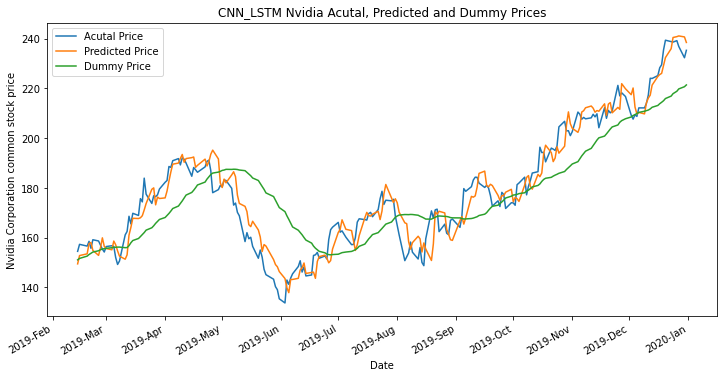

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

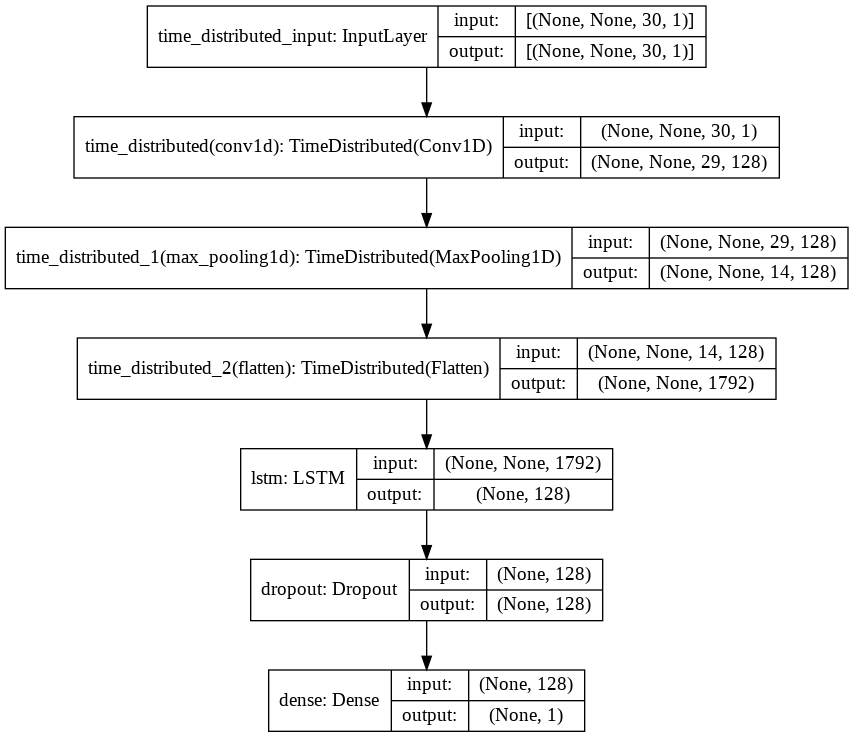

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.004398553684566273
RMSE:  0.0663215928982882
MAE:  0.05306558866559824
Dummy MSE:  0.01623808785220405
Dummy RMSE:  0.12742875598625314
Dummy MAE:  0.10320580289003882


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_LSTM_Nvidia/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_LSTM_Nvidia/assets
